In [ ]:
"""
MIT License

Copyright (c)
  2022 Makarand Pundlik,
  2024 Shanmukh Chatadi, Brian Huynh, Manav Kamdar

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import os
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from pathlib import Path

warnings.filterwarnings('ignore')



def load_and_preprocess_data():
    """
    Load the cab rides data and perform preprocessing.
    """
    # Define the data path
    data_path = '/Users/shanmukh_chatadi/PackTravel-Old/data/cab_rides.csv'
    df_cabs = pd.read_csv(data_path)
    
    # Convert time_stamp from string to integer seconds
    df_cabs['time_stamp'] = df_cabs['time_stamp'].astype(str).str[:-3].astype(np.int64)
    
    # Drop rows with missing values
    df_cabs.dropna(inplace=True)
    
    # Encode categorical variables
    cab_company = pd.get_dummies(df_cabs.cab_type, prefix='cab_type', drop_first=True)
    df_cabs = pd.concat([df_cabs, cab_company], axis=1)
    
    cab_type = pd.get_dummies(df_cabs.name, prefix='name', drop_first=True)
    df_cabs = pd.concat([df_cabs, cab_type], axis=1)
    
    # Convert time_stamp to datetime
    df_cabs['time_stamp'] = pd.to_datetime(df_cabs['time_stamp'], unit='s')
    
    # Feature engineering for time periods
    bins = [0, 3, 6, 17, 22, 24]
    labels = ['LateNight', 'EarlyMorning', 'MorningNoon', 'Night', 'MidNight']
    df_cabs['timePeriodCategory'] = pd.cut(df_cabs['time_stamp'].dt.hour, bins=bins, labels=labels, right=False, include_lowest=True)
    
    time_period = pd.get_dummies(df_cabs['timePeriodCategory'], prefix='timePeriod', drop_first=True)
    df_cabs = pd.concat([df_cabs, time_period], axis=1)
    
    # Weekend and weekday features
    df_cabs['weekend'] = df_cabs['time_stamp'].dt.dayofweek >= 5
    df_cabs['weekend'] = df_cabs['weekend'].astype(int)
    df_cabs['weekday'] = 1 - df_cabs['weekend']
    
    # Drop unnecessary columns
    columns_to_drop = ['destination', 'surge_multiplier', 'source', 'id', 'time_stamp', 'cab_type', 'product_id', 'timePeriodCategory', 'name']
    df_cabs.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    
    # Define features and target
    X = df_cabs.drop('price', axis=1)
    y = df_cabs['price']
    
    return X, y

def train_model(model_name, X_train, y_train):
    """
    Train the specified model with hyperparameter tuning using GridSearchCV or built-in CV.
    Supported models: 'lasso', 'ridge', 'knn', 'random_forest', 'gradient_boosting', 'xgboost', 'svr'
    """
    if model_name == 'lasso':
        # LassoCV has built-in cross-validation, no need for GridSearchCV
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('lassocv', LassoCV(cv=10, random_state=42, max_iter=100000))
        ])
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = {'lassocv_alpha': pipeline.named_steps['lassocv'].alpha_}
        
    elif model_name == 'ridge':
        # RidgeCV has built-in cross-validation
        alphas = np.logspace(-4, 0, 50)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridgecv', RidgeCV(alphas=alphas, cv=10))
        ])
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = {'ridgecv_alpha': pipeline.named_steps['ridgecv'].alpha_}
        
    elif model_name == 'knn':
        # KNN requires GridSearchCV
        param_grid = {
            'kneighborsregressor__n_neighbors': [3,5,7,9],
            'kneighborsregressor__weights': ['uniform', 'distance'],
            'kneighborsregressor__p': [1,2]
        }
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('kneighborsregressor', KNeighborsRegressor())
        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
    elif model_name == 'random_forest':
        # RandomForest requires GridSearchCV
        param_grid = {
            'randomforestregressor__n_estimators': [100, 200],
            'randomforestregressor__max_depth': [None, 10, 20],
            'randomforestregressor__min_samples_split': [2, 5],
            'randomforestregressor__min_samples_leaf': [1, 2],
            'randomforestregressor__bootstrap': [True, False]
        }
        pipeline = Pipeline([
            ('randomforestregressor', RandomForestRegressor(random_state=42))
        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
    elif model_name == 'gradient_boosting':
        # GradientBoostingRegressor requires GridSearchCV
        param_grid = {
            'gradientboostingregressor__n_estimators': [100, 200],
            'gradientboostingregressor__learning_rate': [0.01, 0.1],
            'gradientboostingregressor__max_depth': [3, 5, 7],
            'gradientboostingregressor__min_samples_split': [2, 5],
            'gradientboostingregressor__min_samples_leaf': [1, 2],
        }
        pipeline = Pipeline([
            ('gradientboostingregressor', GradientBoostingRegressor(random_state=42))
        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
    elif model_name == 'xgboost':
        # XGBRegressor requires GridSearchCV
        param_grid = {
            'xgbregressor__n_estimators': [100, 200],
            'xgbregressor__learning_rate': [0.01, 0.1],
            'xgbregressor__max_depth': [3, 5, 7],
            'xgbregressor__subsample': [0.8, 1.0],
            'xgbregressor__colsample_bytree': [0.8, 1.0],
        }
        pipeline = Pipeline([
            ('xgbregressor', XGBRegressor(objective='reg:squarederror', random_state=42))
        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
    elif model_name == 'svr':
        # SVR requires GridSearchCV
        param_grid = {
            'svr__C': [0.1, 1, 10],
            'svr__gamma': ['scale', 'auto'],
            'svr__kernel': ['rbf', 'poly']
        }
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR())
        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
    else:
        raise ValueError("Model not supported. Choose from 'lasso', 'ridge', 'knn', 'random_forest', 'gradient_boosting', 'xgboost'.")
    
    return best_model, best_params

def main():
    # Load and preprocess data
    X, y = load_and_preprocess_data()
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the list of models to train
    models_to_train = ['lasso', 'ridge', 'knn', 'random_forest', 'gradient_boosting', 'xgboost']
    
    # Dictionary to store trained models and their performance
    trained_models = {}
    model_performance = {}
    
    # Define the model directory
    model_dir = Path("/Users/shanmukh_chatadi/PackTravel-Old/cab_model")

    
    for model_name in models_to_train:
        print(f"Training {model_name} model...")
        try:
            best_model, best_params = train_model(model_name, X_train, y_train)
            trained_models[model_name] = best_model
            print(f"Best parameters for {model_name}: {best_params}")
            
            # Make predictions on test set
            if 'scaler' in best_model.named_steps:
                X_test_transformed = best_model.named_steps['scaler'].transform(X_test)
            else:
                X_test_transformed = X_test
            y_pred = best_model.predict(X_test_transformed)
            
            # Calculate evaluation metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            model_performance[model_name] = {
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'Model': best_model
            }
            
            print(f"{model_name} model - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}\n")
            
            # Save the trained model immediately
            model_save_path = model_dir / f"{model_name}_model.pkl"
            joblib.dump(best_model, model_save_path)
            print(f"Saved {model_name} model to {model_save_path}")
            
            # Optionally, save performance metrics incrementally
            performance_save_path = model_dir / f"{model_name}_model_performance.csv"
            performance_df = pd.DataFrame(model_performance).T
            performance_df.to_csv(performance_save_path)
            print(f"Updated model performance metrics at {performance_save_path}\n")
            
        except Exception as e:
            print(f"Error training {model_name}: {e}\n")
    
    # After the loop, select and save the best model
    if not model_performance:
        print("No models were successfully trained.")
        return
    
    best_model_name = min(model_performance, key=lambda x: model_performance[x]['RMSE'])
    best_model = model_performance[best_model_name]['Model']
    
    print(f"The best model is {best_model_name} with RMSE: {model_performance[best_model_name]['RMSE']:.4f}")
    
    # Save the best model separately as 'model.pkl'
    best_model_save_path = model_dir / "model.pkl"
    joblib.dump(best_model, best_model_save_path)
    print(f"Saved best model ({best_model_name}) to {best_model_save_path}")
    
    # Ensure the final performance metrics are saved
    performance_df = pd.DataFrame(model_performance).T
    performance_save_path = model_dir / f"{model_name}_model_performance.csv"
    performance_df.to_csv(performance_save_path)
    print(f"Final model performance metrics saved to {performance_save_path}")

if __name__ == "__main__":
    main()

Training lasso model...
Best parameters for lasso: {'lassocv_alpha': np.float64(0.004659803607587655)}
lasso model - RMSE: 22.5011, MAE: 19.2491, R2: -4.8075

Saved lasso model to /Users/shanmukh_chatadi/PackTravel-Old/cab_model/lasso_model.pkl
Updated model performance metrics at /Users/shanmukh_chatadi/PackTravel-Old/cab_model/lasso_model_performance.csv

Training ridge model...
Best parameters for ridge: {'ridgecv_alpha': np.float64(1.0)}
ridge model - RMSE: 22.3114, MAE: 19.0695, R2: -4.7100

Saved ridge model to /Users/shanmukh_chatadi/PackTravel-Old/cab_model/ridge_model.pkl
Updated model performance metrics at /Users/shanmukh_chatadi/PackTravel-Old/cab_model/ridge_model_performance.csv

Training knn model...
Best parameters for knn: {'kneighborsregressor__n_neighbors': 9, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'uniform'}
knn model - RMSE: 5.6784, MAE: 4.0225, R2: 0.6301

Saved knn model to /Users/shanmukh_chatadi/PackTravel-Old/cab_model/knn_model.pkl
Updat

In [17]:
import joblib

model_path = '/Users/shanmukh_chatadi/PackTravel-Old/cab_model/gradient_boosting_model.pkl'

try:
    trained_model = joblib.load(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully.


In [23]:
import joblib
print(joblib.__version__)


1.4.2


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns



In [12]:
from io import StringIO

model_performance_data = """
,RMSE,MAE,R2,Model
lasso,22.50105210016026,19.249141044559636,-4.807466063190154,"Pipeline(steps=[('scaler', StandardScaler()),
                    ('lassocv', LassoCV(cv=10, max_iter=100000, random_state=42))])"
ridge,22.31138753322048,19.069516867753904,-4.709974772103581,"Pipeline(steps=[('scaler', StandardScaler()),
                    ('ridgecv',
                     RidgeCV(alphas=array([1.00000000e-04, 1.20679264e-04, ...]), cv=10))])"
knn,5.678423378488886,4.022489750636558,0.6301406771799384,"Pipeline(steps=[('scaler', StandardScaler()),
                    ('kneighborsregressor', KNeighborsRegressor(n_neighbors=9))])"
random_forest,2.6209361402739337,1.442235202484988,0.9212058619737751,"Pipeline(steps=[('randomforestregressor',
                     RandomForestRegressor(max_depth=20, min_samples_leaf=2,
                                           min_samples_split=5, n_estimators=200,
                                           random_state=42))])"
gradient_boosting,2.5677891354142597,1.4113267089072155,0.9243690171779336,"Pipeline(steps=[('gradientboostingregressor',
                     GradientBoostingRegressor(max_depth=7, min_samples_leaf=2,
                                               min_samples_split=5,
                                               n_estimators=200,
                                               random_state=42))])"
xgboost,2.5878691266179574,1.4242925731103366,0.9231815307048764,"Pipeline(steps=[('xgbregressor',
                     XGBRegressor(colsample_bytree=1.0, learning_rate=0.1, max_depth=7,
                                  n_estimators=200, random_state=42))])"
"""

# Read the data into a DataFrame
performance_df = pd.read_csv(StringIO(model_performance_data), index_col=0)


In [13]:
# Convert RMSE, MAE, R2 to numeric types
performance_df['RMSE'] = performance_df['RMSE'].astype(float)
performance_df['MAE'] = performance_df['MAE'].astype(float)
performance_df['R2'] = performance_df['R2'].astype(float)


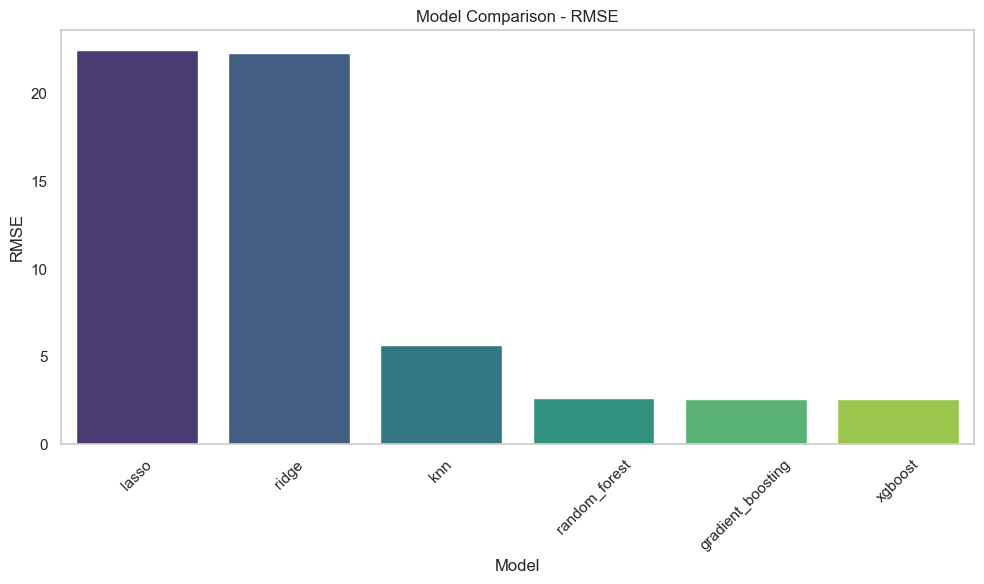

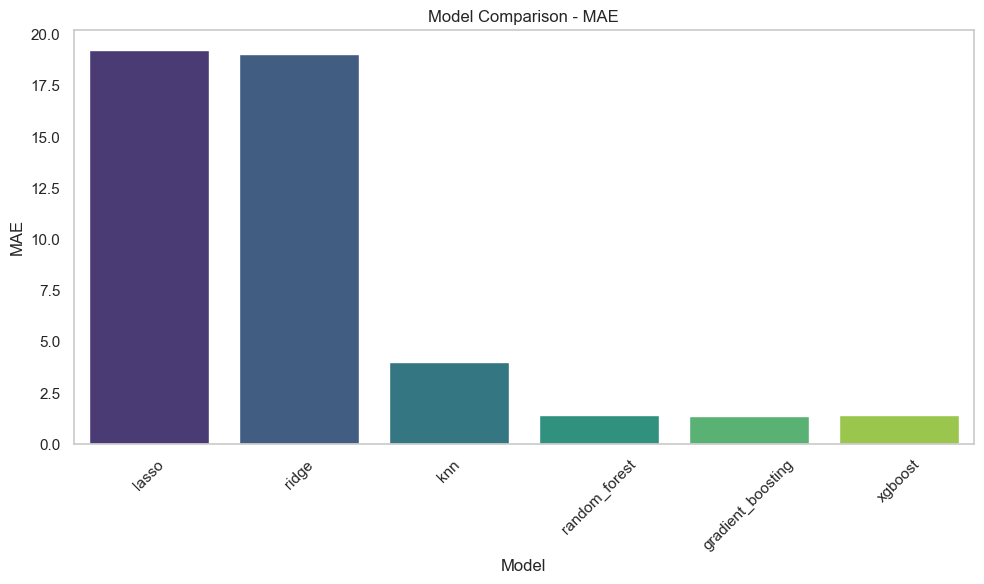

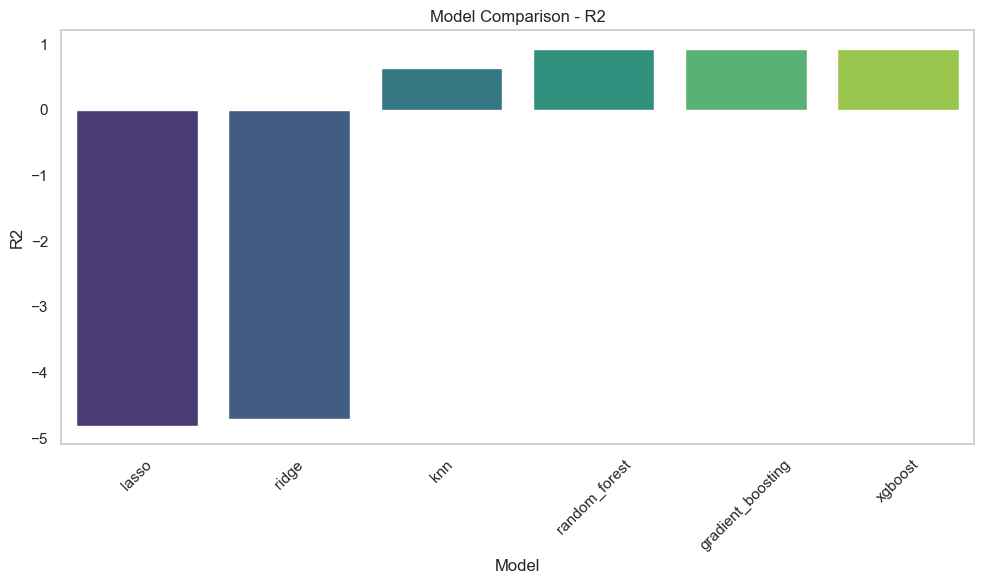

In [14]:
# Set style
sns.set(style='whitegrid')

# Plot RMSE, MAE, and R2 for all models
metrics = ['RMSE', 'MAE', 'R2']
for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=performance_df.index, y=metric, data=performance_df, palette='viridis')
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()



RMSE and MAE: Lower values indicate better model performance.
R²: Values closer to 1 indicate better explanatory power.

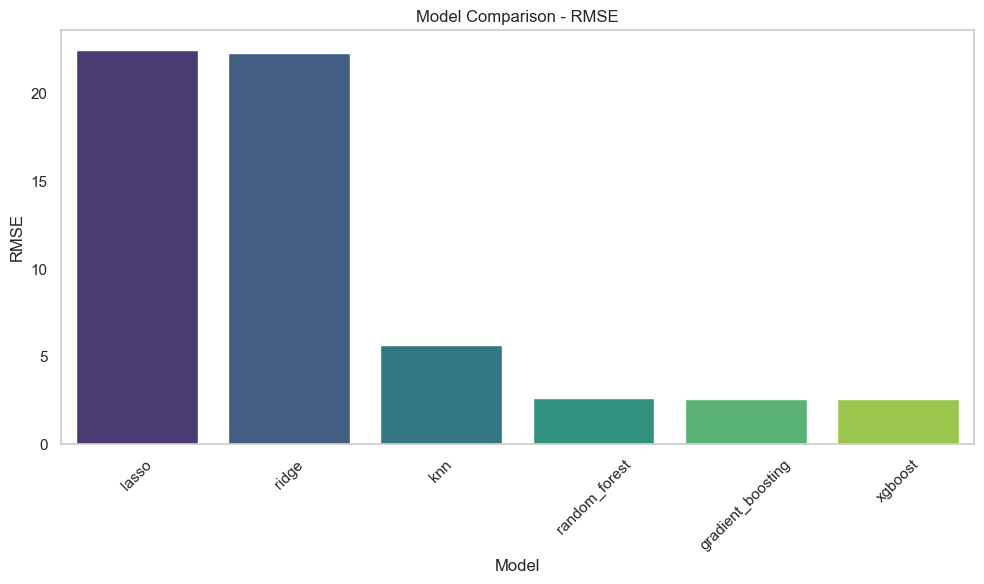

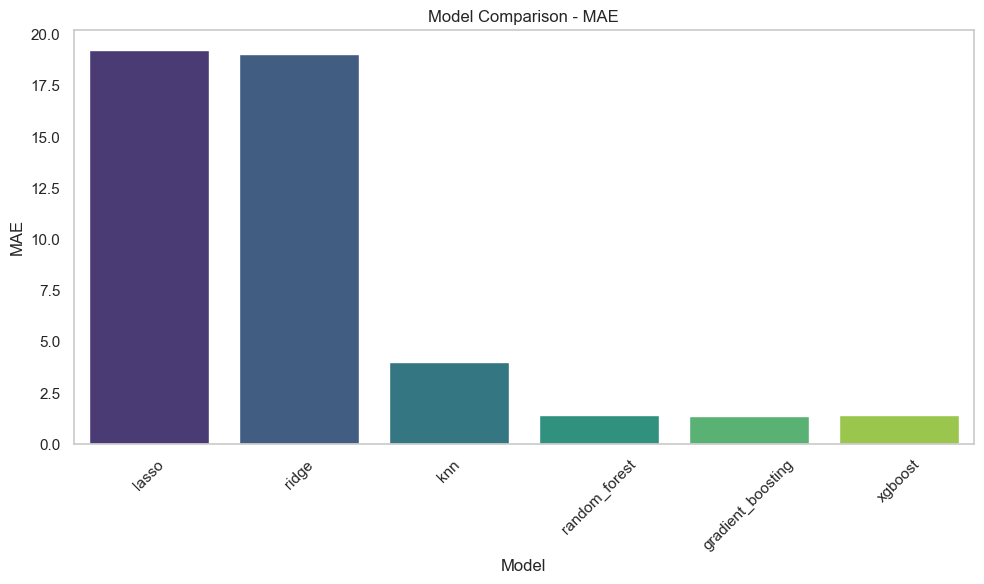

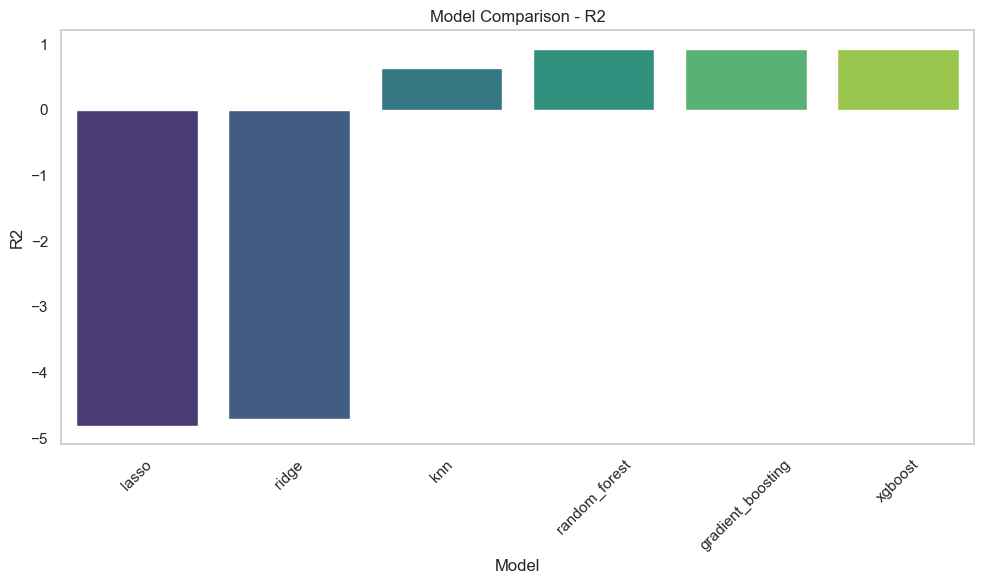

In [16]:
# Set the style for seaborn
sns.set(style='whitegrid')

# List of metrics to plot
metrics = ['RMSE', 'MAE', 'R2']

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=performance_df.index, y=metric, data=performance_df, palette='viridis')
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import warnings
import pickle
from pathlib import Path
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define absolute paths
BASE_DIR = Path(__file__).resolve().parent.parent  # Update this path as needed
DATA_PATH = BASE_DIR / "data" / "cab_rides.csv"
MODEL_DIR = BASE_DIR / "cab_model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)  # Create model directory if it doesn't exist

# Load and preprocess the data
df_cabs = pd.read_csv(DATA_PATH)

# Convert 'time_stamp' from string to integer seconds
df_cabs['time_stamp'] = df_cabs['time_stamp'].astype(str).str[:-3].astype(np.int64)

# Drop rows with missing values
df_cabs.dropna(inplace=True)

# Encode categorical variables
# Cab company
cab_company = pd.get_dummies(df_cabs.cab_type)
cab_company.columns = ['LyftCabs', 'UberCabs']
df_cabs = pd.concat([df_cabs, cab_company], axis=1)

# Cab type
cab_type = pd.get_dummies(df_cabs.name)
df_cabs = pd.concat([df_cabs, cab_type], axis=1)

# Convert 'time_stamp' to datetime
df_cabs['time_stamp'] = pd.to_datetime(df_cabs['time_stamp'], unit='s')

# Feature engineering for time periods using the same logic as in predict.py
df_cabs['timePeriodCategory'] = df_cabs.time_stamp.apply(
    lambda date: "EarlyMorning" if 3 <= date.hour <= 6 else
                 "MorningNoon" if 6 < date.hour <= 17 else
                 "Night" if 17 < date.hour <= 22 else
                 "LateNight"
)

# Encode time period categories without dropping any columns
time_period = pd.get_dummies(df_cabs.timePeriodCategory)
df_cabs = pd.concat([df_cabs, time_period], axis=1)

# Weekend and weekday features
df_cabs['weekend'] = df_cabs['time_stamp'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)
df_cabs['weekday'] = 1 - df_cabs['weekend']

# Drop unnecessary columns
columns_to_drop = ['destination', 'surge_multiplier', 'source', 'id', 'time_stamp', 'cab_type', 'product_id', 'timePeriodCategory', 'name']
df_cabs.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define features and target
X = df_cabs.loc[:, df_cabs.columns != 'price']
y = df_cabs['price']

# Save the feature names for later use in prediction
feature_names = X.columns.tolist()

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_gradient_boosting(x_train, y_train):
    """
    Train a Gradient Boosting Regressor to predict cab prices.
    """
    # Initialize the model with hyperparameters (adjust as needed)
    gbr = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
    # Fit the model
    gbr.fit(x_train, y_train)
    return gbr

# Train the Gradient Boosting model
model_gbr = train_gradient_boosting(X_train, y_train)

# Evaluate the model on the test set
y_pred = model_gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Gradient Boosting Regressor Performance on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}\n")

# Save the trained model using pickle
save_model_path = MODEL_DIR / "model.pkl"
with open(save_model_path, "wb") as f:
    pickle.dump(model_gbr, f)
print(f"Saved Gradient Boosting model to {save_model_path}")

# Save the feature names to ensure consistency during prediction
feature_names_path = MODEL_DIR / "feature_names.pkl"
with open(feature_names_path, "wb") as f:
    pickle.dump(feature_names, f)
print(f"Saved feature names to {feature_names_path}")


Gradient Boosting Regressor Performance on Test Set:
RMSE: 2.5790
MAE: 1.4213
R2 Score: 0.9237

Saved Gradient Boosting model to /Users/shanmukh_chatadi/PackTravel-Old/cab_model/model.pkl
Saved feature names to /Users/shanmukh_chatadi/PackTravel-Old/cab_model/feature_names.pkl


In [ ]:
import pandas as pd
import numpy as np
import warnings
import pickle
from pathlib import Path
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define absolute paths
BASE_DIR = Path(__file__).resolve().parent.parent # Update this path as needed
DATA_PATH = BASE_DIR / "data" / "cab_rides.csv"
MODEL_DIR = BASE_DIR / "cab_model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)  # Create model directory if it doesn't exist

# Load and preprocess the data
df_cabs = pd.read_csv(DATA_PATH)

# Convert 'time_stamp' from string to integer seconds
df_cabs['time_stamp'] = df_cabs['time_stamp'].astype(str).str[:-3].astype(np.int64)

# Drop rows with missing values
df_cabs.dropna(inplace=True)

# Encode categorical variables
# Cab company
cab_company = pd.get_dummies(df_cabs.cab_type)
cab_company.columns = ['LyftCabs', 'UberCabs']
df_cabs = pd.concat([df_cabs, cab_company], axis=1)

# Cab type (name)
cab_type = pd.get_dummies(df_cabs.name)
df_cabs = pd.concat([df_cabs, cab_type], axis=1)

# Convert 'time_stamp' to datetime
df_cabs['time_stamp'] = pd.to_datetime(df_cabs['time_stamp'], unit='s')

# Feature engineering for time periods using the same logic as in predict.py
df_cabs['timePeriodCategory'] = df_cabs.time_stamp.apply(
    lambda date: "EarlyMorning" if 3 <= date.hour <= 6 else
                 "MorningNoon" if 6 < date.hour <= 17 else
                 "Night" if 17 < date.hour <= 22 else
                 "LateNight"
)

# Encode time period categories without dropping any columns
time_period = pd.get_dummies(df_cabs.timePeriodCategory)
df_cabs = pd.concat([df_cabs, time_period], axis=1)

# Weekend and weekday features
df_cabs['weekend'] = df_cabs['time_stamp'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)
df_cabs['weekday'] = 1 - df_cabs['weekend']

# Drop unnecessary columns
columns_to_drop = [
    'destination', 'surge_multiplier', 'source', 'id', 'time_stamp',
    'cab_type', 'product_id', 'timePeriodCategory', 'name'
]
df_cabs.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define features and target
X = df_cabs.loc[:, df_cabs.columns != 'price']
y = df_cabs['price']

# Save the feature names for later use in prediction
feature_names = X.columns.tolist()

# Print the number of features and feature names
print(f"Number of features: {len(feature_names)}")
print("Features used in training:")
for feature in feature_names:
    print(feature)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_gradient_boosting(x_train, y_train):
    """
    Train a Gradient Boosting Regressor to predict cab prices.
    """
    # Initialize the model with hyperparameters (adjust as needed)
    gbr = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
    # Fit the model
    gbr.fit(x_train, y_train)
    return gbr

# Train the Gradient Boosting model
model_gbr = train_gradient_boosting(X_train, y_train)

# Evaluate the model on the test set
y_pred = model_gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nGradient Boosting Regressor Performance on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}\n")

# Save the trained model using pickle
save_model_path = MODEL_DIR / "model.pkl"
with open(save_model_path, "wb") as f:
    pickle.dump(model_gbr, f)
print(f"Saved Gradient Boosting model to {save_model_path}")

# Save the feature names to ensure consistency during prediction
feature_names_path = MODEL_DIR / "feature_names.pkl"
with open(feature_names_path, "wb") as f:
    pickle.dump(feature_names, f)
print(f"Saved feature names to {feature_names_path}")


Number of features: 21
Features used in training:
distance
LyftCabs
UberCabs
Black
Black SUV
Lux
Lux Black
Lux Black XL
Lyft
Lyft XL
Shared
UberPool
UberX
UberXL
WAV
EarlyMorning
LateNight
MorningNoon
Night
weekend
weekday

Gradient Boosting Regressor Performance on Test Set:
RMSE: 2.5790
MAE: 1.4213
R2 Score: 0.9237

Saved Gradient Boosting model to /Users/shanmukh_chatadi/PackTravel-Old/cab_model/model.pkl
Saved feature names to /Users/shanmukh_chatadi/PackTravel-Old/cab_model/feature_names.pkl
